# import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,find_peaks

from tqdm import tqdm

import time

from impedance.visualization import plot_nyquist
from impedance import preprocessing

from sklearn.cluster import KMeans

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# import raw data to MySQL

## read mpr files to pandas dataframe

### read Formation data

In [2]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

#file fullname
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [3]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

##### half cycle and state of charge

In [4]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [5]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

array([ 3,  7, 11, 15, 19, 23, 27, 31])

### read Cycling data

In [6]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle')

read_mpr.searchmpr('raw_data/cycle')

['raw_data/cycle\\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_01_GEIS_CA1.mpr',
 'raw_data/cycle\\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA1.mpr',
 'raw_data/cycle\\Cell002_Cyc_20uA_25T_30RH_Cycle11to100_01_GEIS_CA2.mpr',
 'raw_data/cycle\\Cell002_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA2.mpr',
 'raw_data/cycle\\Cell003_Cyc_50uA_25T_30RH_Cycle11to100_01_GEIS_CA3.mpr',
 'raw_data/cycle\\Cell003_Cyc_50uA_25T_30RH_Cycle11to100_02_GCPL_CA3.mpr',
 'raw_data/cycle\\Cell004_Cyc_50uA_25T_30RH_Cycle11to100_01_GEIS_CA4.mpr',
 'raw_data/cycle\\Cell004_Cyc_50uA_25T_30RH_Cycle11to100_02_GCPL_CA4.mpr',
 'raw_data/cycle\\Cell005_Cyc_100uA_25T_30RH_Cycle11to100_01_GEIS_CA5.mpr',
 'raw_data/cycle\\Cell005_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA5.mpr',
 'raw_data/cycle\\Cell006_Cyc_100uA_25T_30RH_Cycle11to100_01_GEIS_CA6.mpr',
 'raw_data/cycle\\Cell006_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA6.mpr',
 'raw_data/cycle\\Cell007_Cyc_200uA_25T_30RH_Cycle11to100_01_GEIS_CA7.mpr',
 'raw_data/cycle\\Ce

In [7]:
# sometimes the error appears
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

similar issue: https://github.com/echemdata/galvani/issues/39

# import dataframes to Mysql

## Structure based on test types:    
  -geis    
  -gcpl    

In [8]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
datafilespath_form = glob('raw_data/form/*.mpr')
datafilespath_form = [os.path.basename(x) for x in datafilespath_form]
datafilespath_cyc = glob('raw_data/cycle/*.mpr')
datafilespath_cyc = [os.path.basename(x) for x in datafilespath_cyc]
datafilespath = np.append(datafilespath_form,datafilespath_cyc)
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')


##formation data
Cell_ID = np.unique([x.split('_')[0] for x in datafilespath_form])#[cell001,cell002...]
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath_form],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath_form]
print('='*100+'\nForm data:')
form_start_time = time.time()
chunksize = 5000
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath_form]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([df_form[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('form_geis', engine, if_exists='fail',index=False,chunksize = chunksize)
    print('geis data of '+Cell_ID[i]+ ' uploaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([df_form[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('form_gcpl', engine, if_exists='fail',index=False,chunksize = chunksize)    
    print('gcpl data of '+Cell_ID[i]+ ' uploaded')    

form_end_time = time.time()
print('formation data processing time: ', form_end_time - form_start_time,'s')
print('='*100+'\nCycle data:')

##cycling data   
db=np.unique([x.split('_')[0] for x in datafilespath_cyc])
cyc_start_time = time.time()
for cell,index in zip(db,range(0,26,2)):
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    df_cycle[index].to_sql('cyc_geis', engine, if_exists='replace',index=False,chunksize = chunksize)
    print('geis data of '+cell+ ' uploaded')
    df_cycle[index+1].to_sql('cyc_gcpl', engine, if_exists='replace',index=False,chunksize = chunksize)
    print('gcpl data of '+cell+ ' uploaded')
    
print('='*100)
print('All data uploaded')

cyc_end_time = time.time()

print('cycling data processing time: ', cyc_end_time - cyc_start_time,'s')


connection succeed
table cell_configuration created
Form data:
geis data of Cell001 uploaded
gcpl data of Cell001 uploaded
geis data of Cell002 uploaded
gcpl data of Cell002 uploaded
geis data of Cell003 uploaded
gcpl data of Cell003 uploaded
geis data of Cell004 uploaded
gcpl data of Cell004 uploaded
geis data of Cell005 uploaded
gcpl data of Cell005 uploaded
geis data of Cell006 uploaded
gcpl data of Cell006 uploaded
geis data of Cell007 uploaded
gcpl data of Cell007 uploaded
geis data of Cell008 uploaded
gcpl data of Cell008 uploaded
formation data processing time:  95.14145565032959 s
Cycle data:
geis data of Cell001 uploaded
gcpl data of Cell001 uploaded
geis data of Cell002 uploaded
gcpl data of Cell002 uploaded
geis data of Cell003 uploaded
gcpl data of Cell003 uploaded
geis data of Cell004 uploaded
gcpl data of Cell004 uploaded
geis data of Cell005 uploaded
gcpl data of Cell005 uploaded
geis data of Cell006 uploaded
gcpl data of Cell006 uploaded
geis data of Cell007 uploaded
gc

without chunksize:    
    formation data processing time:  249.83825254440308 s    
    cycling data processing time:  1045.3779447078705 s
   
chunksize = 50000(best one!)   
    formation data processing time:  184.6444227695465 s    
    cycling data processing time:  921.2041549682617 s

chunksize = 5000    
    formation data processing time:  212.5893361568451 s    
    cycling data processing time:  1058.742508172989 s
    
chunksize = 10000   
    formation data processing time:  214.2786316871643 s    
    cycling data processing time:  1023.5620315074921 s

chunksize = 30000   
    formation data processing time:  215.41345477104187 s    
    cycling data processing time:  1060.0271468162537 s


# Savitzky-Golay filter

## charge/discharge curve

In [9]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)

# structue 2
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` FROM form_gcpl WHERE loop_Nr=0'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

<IPython.core.display.Javascript object>


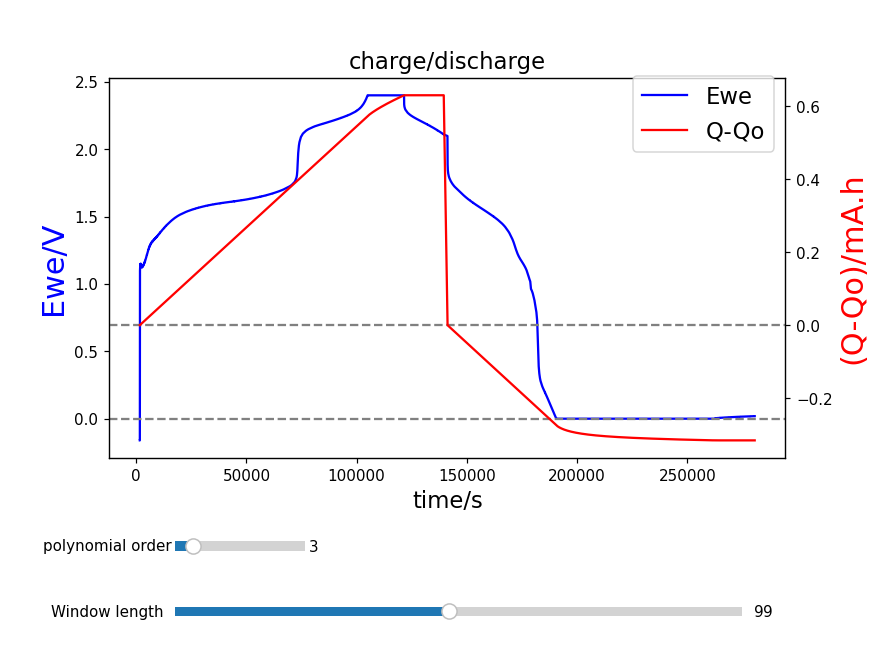

In [10]:
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,1], "b-",label='Ewe')
ax.axhline(0,color='grey',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("Ewe/V",color="blue",fontsize=20)

ax2=ax.twinx()
ax2.axhline(0,color='grey',linestyle='--')
ax2.plot(curve[:,2], curve[:,0],color="red",label='Q-Qo')
ax2.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=20)


# p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y",label='filtered Ewe')

fig.legend(bbox_to_anchor=(0.9, 0.9), loc='upper right', fontsize=15)
## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


In [11]:
sql = 'SELECT dV,dV_sg,t FROM derivative_of_v_to_time_form WHERE loop_Nr=0'
cellx_df = pd.read_sql(sql, Connection)
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('dV with/without S-G filter',fontsize=15)
ax.plot( cellx_df['t'],cellx_df['dV_sg'], color="red",label='dV_sg')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("dV",fontsize=15)

ax.plot(cellx_df['t'],cellx_df['dV'], "b-",label='dV')



fig.legend()


plt.show()


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\866592715.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


DatabaseError: Execution failed on sql 'SELECT dV,dV_sg,t FROM derivative_of_v_to_time_form WHERE loop_Nr=0': (1146, "Table 'cell001.derivative_of_v_to_time_form' doesn't exist")

# Fix error in cycling data

## check the abnormal parts

In [12]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structue 2
sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
print('data queried')
cell_df = pd.read_sql(sql,Connection)

data queried


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\241541614.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


<IPython.core.display.Javascript object>


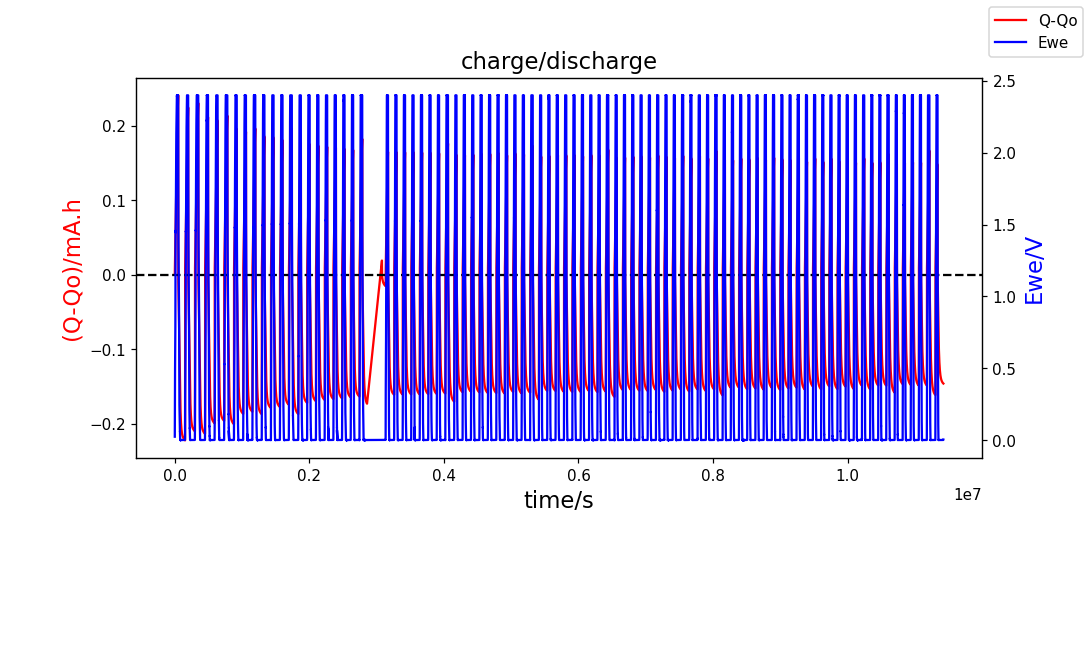

In [13]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(cell_df['time/s'], cell_df['Q charge/discharge/mA.h'], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(cell_df['time/s'], cell_df['Ewe/V'],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)
fig.legend()



plt.show()

<IPython.core.display.Javascript object>


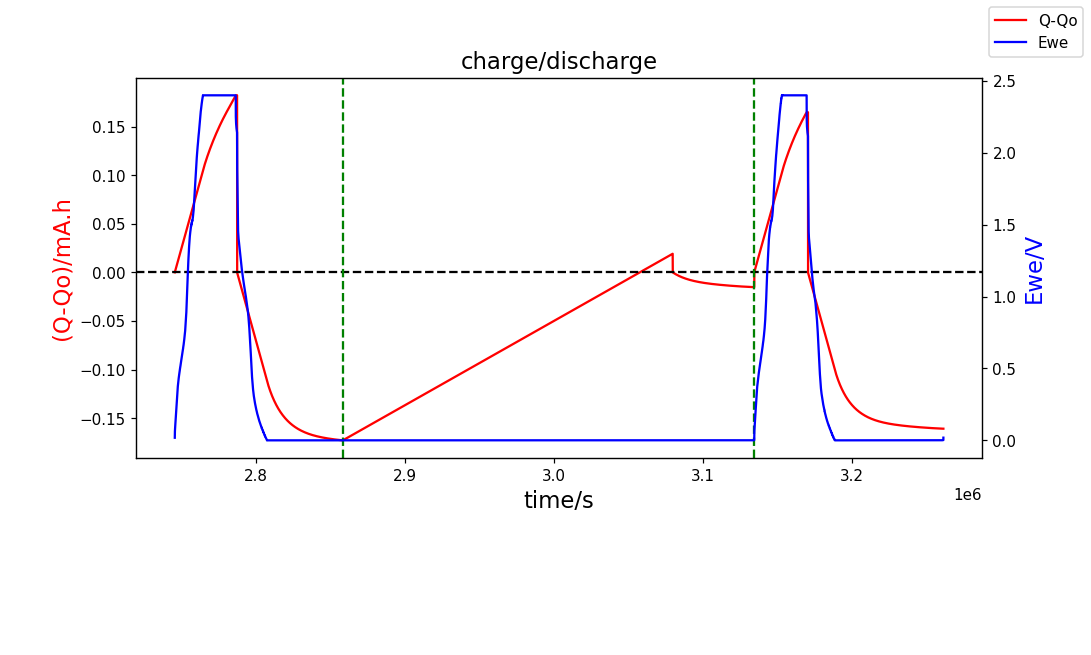

In [14]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
error_index = np.isin(cell_df['cycle_Nr'],[31,32,33])
ax.plot(cell_df['time/s'][error_index], cell_df['Q charge/discharge/mA.h'][error_index], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

#vertical lines to distinguish different cycle
time_31_32 = cell_df['time/s'][cell_df['cycle_Nr']==31].max()
time_32_33 = cell_df['time/s'][cell_df['cycle_Nr']==32].max()
ax.axvline(time_31_32,color='green',linestyle='--')
ax.axvline(time_32_33,color='green',linestyle='--')

ax2=ax.twinx()
ax2.plot(cell_df['time/s'][error_index], cell_df['Ewe/V'][error_index],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)

fig.legend()



plt.show()

The whole cycle 32 looks weird.

In [15]:
t_30 = cell_df['time/s'][cell_df['cycle_Nr']==30].max() - cell_df['time/s'][cell_df['cycle_Nr']==30].min()
t_31 = cell_df['time/s'][cell_df['cycle_Nr']==31].max() - cell_df['time/s'][cell_df['cycle_Nr']==31].min()
t_32 = cell_df['time/s'][cell_df['cycle_Nr']==32].max() - cell_df['time/s'][cell_df['cycle_Nr']==32].min()
t_33 = cell_df['time/s'][cell_df['cycle_Nr']==33].max() - cell_df['time/s'][cell_df['cycle_Nr']==33].min()
t_34 = cell_df['time/s'][cell_df['cycle_Nr']==34].max() - cell_df['time/s'][cell_df['cycle_Nr']==34].min()
print('time of cycle 30: '+str(round(t_30))+'s')
print('time of cycle 31: '+str(round(t_31))+'s')
print('time of cycle 32: '+str(round(t_32))+'s')
print('time of cycle 33: '+str(round(t_33))+'s')
print('time of cycle 34: '+str(round(t_34))+'s')

time of cycle 30: 129551s
time of cycle 31: 112726s
time of cycle 32: 54736s
time of cycle 33: 126921s
time of cycle 34: 126682s


## find the cycle number

In [16]:
def find_error_cycle_numbers(cell_df):
    cycle_numbers = []
    for i in  tqdm(range(1, len(cell_df['time/s']))):
        if cell_df['time/s'][i]-cell_df['time/s'][i-1]>10000:
            return [cell_df['cycle_Nr'][i-1],cell_df['cycle_Nr'][i]]
    

In [17]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cells=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

cyc = []
for cell in cells:
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)

    sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
    print(cell,' data queried')
    cell_df = pd.read_sql(sql,Connection)
    cyc.append(find_error_cycle_numbers(cell_df))
cyc

cell001  data queried


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)
 26%|█████████████████▌                                                   | 570958/2238400 [00:03<00:09, 175679.10it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell002  data queried


 27%|██████████████████▉                                                  | 570619/2077525 [00:03<00:08, 176433.05it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell003  data queried


 34%|███████████████████████▋                                             | 570383/1658454 [00:03<00:06, 173414.43it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell004  data queried


 35%|████████████████████████▏                                            | 570039/1624061 [00:03<00:06, 175170.24it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell005  data queried


 36%|████████████████████████▉                                            | 569400/1573494 [00:03<00:05, 175088.27it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell006  data queried


 38%|██████████████████████████                                           | 569073/1504412 [00:03<00:05, 173676.10it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell007  data queried


 38%|██████████████████████████▎                                          | 568751/1493751 [00:03<00:05, 173338.13it/s]
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\3429346790.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cell_df = pd.read_sql(sql,Connection)


cell008  data queried


 38%|█████████████████████████▉                                           | 568400/1509068 [00:03<00:05, 176772.52it/s]


[[31, 32],
 [32, 32],
 [39, 40],
 [39, 40],
 [41, 42],
 [43, 43],
 [43, 44],
 [43, 43]]

## remove these cycles

In [18]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cells = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cycles,cell in  zip(cyc,cells):
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)
    cycles = np.unique(cycles)
    if len (cycles) == 1:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={}'.format(cycles[0])
    else:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={} or cycle_Nr={}'.format(cycles[0],cycles[1])
    cursor = Connection.cursor()
    cursor.execute(sql)
    Connection.commit()
    print('deleted from {}'.format(cell))

deleted from cell001
deleted from cell002
deleted from cell003
deleted from cell004
deleted from cell005
deleted from cell006
deleted from cell007
deleted from cell008


# cell capacity and relative capacity

In [19]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Test'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
    #formation
    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]

    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity_form = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,
                     'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2),
                     'Q_relative':np.round(np.divide(discharge,0.2)*100,2)}
    capacity_form['cycle type'] = 'Formation'
    capacity_form = pd.DataFrame(data=capacity_form)


    
    #cycling
    sql = 'SELECT `Q charge/discharge/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['Q charge/discharge/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['Q charge/discharge/mA.h'].min())
    capacity_cycle = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,
                      'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2),'Q_relative':np.round(np.divide(discharge,0.2)*100,2)}
    capacity_cycle['cycle type'] = 'Cycling'
    capacity_cycle = pd.DataFrame(data=capacity_cycle,index=cycle_Nr)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    
    capacity = pd.concat([capacity_form,capacity_cycle])
#     print(capacity[0:10])
    Q_rated = capacity['Q_discharge'][4]  #Set Q_discharge of 5th cycle as cells rated capacity
#     print(Q_rated)
    capacity['Q_relative'] = np.round((capacity['Q_discharge']/Q_rated),2)

    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell001 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell002 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell003 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell004 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell005 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell006 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell007 created


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2492\2536905590.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


table capacity of Cell008 created
